# GridMask data augmentation
Type of image data augmentation can be rougly divided in to 3 categories : 

1. Spatial transformation (random-crop, flip, rotation...)
2. Color distortion (random gamma, brightness, hue, contrast....)
3. Information dropping (random cutout, random erasing, hide-and-seek..)


GridMask is belong to Information dropping method. Information dropping might help improving model generalization through enforcing model to learn on remain information. But keeping the deletion and reservation region in a balance relation is needed. Too much information dropping might result in under-fitting, but too few might result in over-fitting. <br />
There are also some concerns in old information dropping methods. Since the region they dropped will be randomly. So the information might be totally gone after dropping, which make the data into noise. GridMask deletes the structured regions which are uniformly distributed squares. Since the deleting regions are continuous distributed, so the information missing problem can be improve.

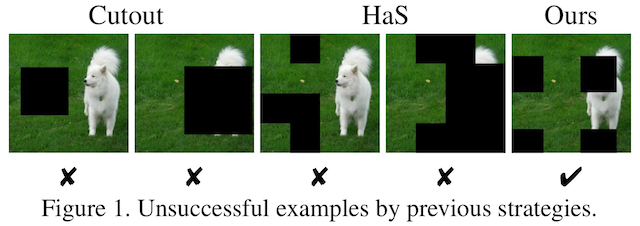


Image rotation is refer to Chris's great [kernel](https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96) and add some of mine code in it. Which can rotate image with different aspect ratio. I also implemented some data augmentation methods(gaussian blur, random cutout..) in this [kernel](https://www.kaggle.com/xiejialun/customize-data-augmentation-with-tensorflow).


My Github repo : [GridMask_tensorflow(not official)](https://github.com/RayXie29/GridMask_Tensorflow) <br />
Official GridMask implementation in pytorch : [GridMask](https://github.com/akuxcw/GridMask) <br />
Paper : [GridMask Data Augmentation](https://arxiv.org/abs/2001.04086) <br />

In [ ]:
import os
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets

print('Tensorflow version : {}'.format(tf.__version__))

In [ ]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path('flower-classification-with-tpus')
GCS_PATH = os.path.join(GCS_DS_PATH, 'tfrecords-jpeg-512x512')
TEST_FNS = tf.io.gfile.glob(os.path.join(GCS_PATH, 'test/*.tfrec'))
IMG_DIM = (512, 512)

In [ ]:
AugParams = {
    'd1' : 100,
    'd2': 160,
    'rotate' : 45,
    'ratio' : 0.5
}

In [ ]:
def transform(image, inv_mat, image_shape):

    h, w, c = image_shape
    cx, cy = w//2, h//2

    new_xs = tf.repeat( tf.range(-cx, cx, 1), h)
    new_ys = tf.tile( tf.range(-cy, cy, 1), [w])
    new_zs = tf.ones([h*w], dtype=tf.int32)

    old_coords = tf.matmul(inv_mat, tf.cast(tf.stack([new_xs, new_ys, new_zs]), tf.float32))
    old_coords_x, old_coords_y = tf.round(old_coords[0, :] + w//2), tf.round(old_coords[1, :] + h//2)

    clip_mask_x = tf.logical_or(old_coords_x<0, old_coords_x>w-1)
    clip_mask_y = tf.logical_or(old_coords_y<0, old_coords_y>h-1)
    clip_mask = tf.logical_or(clip_mask_x, clip_mask_y)

    old_coords_x = tf.boolean_mask(old_coords_x, tf.logical_not(clip_mask))
    old_coords_y = tf.boolean_mask(old_coords_y, tf.logical_not(clip_mask))
    new_coords_x = tf.boolean_mask(new_xs+cx, tf.logical_not(clip_mask))
    new_coords_y = tf.boolean_mask(new_ys+cy, tf.logical_not(clip_mask))

    old_coords = tf.cast(tf.stack([old_coords_y, old_coords_x]), tf.int32)
    new_coords = tf.cast(tf.stack([new_coords_y, new_coords_x]), tf.int64)
    rotated_image_values = tf.gather_nd(image, tf.transpose(old_coords))
    rotated_image_channel = list()
    for i in range(c):
        vals = rotated_image_values[:,i]
        sparse_channel = tf.SparseTensor(tf.transpose(new_coords), vals, [h, w])
        rotated_image_channel.append(tf.sparse.to_dense(sparse_channel, default_value=0, validate_indices=False))

    return tf.transpose(tf.stack(rotated_image_channel), [1,2,0])

def random_rotate(image, angle, image_shape):

    def get_rotation_mat_inv(angle):
          #transform to radian
        angle = math.pi * angle / 180

        cos_val = tf.math.cos(angle)
        sin_val = tf.math.sin(angle)
        one = tf.constant([1], tf.float32)
        zero = tf.constant([0], tf.float32)

        rot_mat_inv = tf.concat([cos_val, sin_val, zero,
                                     -sin_val, cos_val, zero,
                                     zero, zero, one], axis=0)
        rot_mat_inv = tf.reshape(rot_mat_inv, [3,3])

        return rot_mat_inv
    angle = float(angle) * tf.random.normal([1],dtype='float32')
    rot_mat_inv = get_rotation_mat_inv(angle)
    return transform(image, rot_mat_inv, image_shape)


def GridMask(image_height, image_width, d1, d2, rotate_angle=1, ratio=0.5):

    h, w = image_height, image_width
    hh = int(np.ceil(np.sqrt(h*h+w*w)))
    hh = hh+1 if hh%2==1 else hh
    d = tf.random.uniform(shape=[], minval=d1, maxval=d2, dtype=tf.int32)
    l = tf.cast(tf.cast(d,tf.float32)*ratio+0.5, tf.int32)

    st_h = tf.random.uniform(shape=[], minval=0, maxval=d, dtype=tf.int32)
    st_w = tf.random.uniform(shape=[], minval=0, maxval=d, dtype=tf.int32)

    y_ranges = tf.range(-1 * d + st_h, -1 * d + st_h + l)
    x_ranges = tf.range(-1 * d + st_w, -1 * d + st_w + l)

    for i in range(0, hh//d+1):
        s1 = i * d + st_h
        s2 = i * d + st_w
        y_ranges = tf.concat([y_ranges, tf.range(s1,s1+l)], axis=0)
        x_ranges = tf.concat([x_ranges, tf.range(s2,s2+l)], axis=0)

    x_clip_mask = tf.logical_or(x_ranges <0 , x_ranges > hh-1)
    y_clip_mask = tf.logical_or(y_ranges <0 , y_ranges > hh-1)
    clip_mask = tf.logical_or(x_clip_mask, y_clip_mask)

    x_ranges = tf.boolean_mask(x_ranges, tf.logical_not(clip_mask))
    y_ranges = tf.boolean_mask(y_ranges, tf.logical_not(clip_mask))

    hh_ranges = tf.tile(tf.range(0,hh), [tf.cast(tf.reduce_sum(tf.ones_like(x_ranges)), tf.int32)])
    x_ranges = tf.repeat(x_ranges, hh)
    y_ranges = tf.repeat(y_ranges, hh)

    y_hh_indices = tf.transpose(tf.stack([y_ranges, hh_ranges]))
    x_hh_indices = tf.transpose(tf.stack([hh_ranges, x_ranges]))

    y_mask_sparse = tf.SparseTensor(tf.cast(y_hh_indices, tf.int64),  tf.zeros_like(y_ranges), [hh, hh])
    y_mask = tf.sparse.to_dense(y_mask_sparse, 1, False)

    x_mask_sparse = tf.SparseTensor(tf.cast(x_hh_indices, tf.int64), tf.zeros_like(x_ranges), [hh, hh])
    x_mask = tf.sparse.to_dense(x_mask_sparse, 1, False)

    mask = tf.expand_dims( tf.clip_by_value(x_mask + y_mask, 0, 1), axis=-1)

    mask = random_rotate(mask, rotate_angle, [hh, hh, 1])
    mask = tf.image.crop_to_bounding_box(mask, (hh-h)//2, (hh-w)//2, image_height, image_width)

    return mask

def apply_grid_mask(image, image_shape):
    mask = GridMask(image_shape[0],
                    image_shape[1],
                    AugParams['d1'],
                    AugParams['d2'],
                    AugParams['rotate'],
                    AugParams['ratio'])
    
    if image_shape[-1] == 3:
        mask = tf.concat([mask, mask, mask], axis=-1)

    return image * tf.cast(mask, tf.uint8)

In [ ]:
def augmentation(image):
    
    if tf.random.uniform(shape=[], minval=0.0, maxval=1.0) >=0.5:
        image = apply_grid_mask(image, (*IMG_DIM,3))
    return tf.cast(image, tf.uint8)
    
def decoded_example(example):
    example = tf.io.parse_single_example(example, { "image" : tf.io.FixedLenFeature([], tf.string) })
    bits = example['image']
    image = tf.image.decode_jpeg(bits)
    return image

ds = tf.data.TFRecordDataset(TEST_FNS)
ds = ds.map(decoded_example)
ds = ds.map(augmentation)
ds = ds.batch(25)

In [ ]:
images = next(iter(ds))
images = images.numpy()
plt.figure(figsize=(24,24))
col = 5
row = 5
for idx, image in enumerate(images):
    plt.subplot(row, col, idx+1)
    plt.imshow(image)
plt.show()